# This notebook is used to calculate and plot ensemble temperature figures for PMIP4 midHolocene paper.

### Import packages and define fucntions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import seaborn as sns
import scipy
from sklearn.metrics import mean_squared_error
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF


In [2]:
#No change needs here
 #PMIP model list used in this notebook represents CMIP models included in PMIP
'''Define CMIP list'''

def whole_model_list():
    filename_xls='PMIP & CMIP model data status.xlsx'
    wb=xlrd.open_workbook(filename_xls)
    sh_pmip4 = wb.sheet_by_name('PMIP4-CMIP6')
    model_id4=sh_pmip4.col_values(14, 6, 28)
    cmip6=[]
    cmip6_generation=sh_pmip4.col_values(20, 6, 28)
    pmip4_generation=sh_pmip4.col_values(21, 6, 28)
    for i in range(len(model_id4)):
        if (cmip6_generation[i]=='CMIP6' and pmip4_generation[i]=='PMIP4'):
            cmip6.append(model_id4[i])
    cmip5=[]
    sh_pmip3 = wb.sheet_by_name('PMIP3-CMIP5')
    model_id3=sh_pmip3.col_values(12, 2, 20)
    cmip5_generation=sh_pmip3.col_values(18, 2, 20)
    pmip3_generation=sh_pmip3.col_values(19, 2, 20)
    for i in range(len(model_id3)):
        if (cmip5_generation[i]=='CMIP5' and pmip3_generation[i]=='PMIP3'):
            cmip5.append(model_id3[i])
    return model_id4,cmip6,model_id3,cmip5

#PMIP4-CMIP6
#Cell range: B6 - X28
#Below: No values are corresponed No in python
# model row No.: 6-27
# col_No. col.  experiment/column content

#    4      E    0kpiControl
#    5      F    LMpast1000(1000 years)
#    6      G    6kmidHolocene
#    7      H    21klgm
#    8      I    Last Interglaciallig127k
#    9      J    Mid Pliocene warm periodmidPliocene-eoi400

#    14     O    Model id
#    20     U    CMIP6
#    21     V    PMIP4

#PMIP3-CMIP5
#Cell range: B2 - U20
#Below: No values are corresponed No in python
# model row No.: 2-19
# col_No. col.  experiment/column content

#    3      D    0kpiControl
#    4      E    LMpast1000(1000 years)
#    5      F    6kmidHolocene
#    6      G    21klgm
#    7      H    Last Interglaciallig127k
#    8      I    Mid Pliocene warm periodmidPliocene-eoi400   

#    12     M    Model id
#    18     S    CMIP6
#    19     T    PMIP4


pmip4,cmip6,pmip3,cmip5=whole_model_list()

pmip={}
pmip['PMIP3']=cmip5
pmip['PMIP4']=cmip6

pmip_v4='PMIP4'
pmip_v3='PMIP3'

In [2]:
pmip={}
pmip['PMIP4']=['AWI-CM-1-1-LR',
               'CESM2',
               'EC-EARTH-3-3',
               'FGOALS-f3-L',
               'FGOALS-g3',
               'GISS-E2-1-G',
               'HadGEM3-GC31',
               'IPSL-CM6A-LR',
               'MIROC-ES2L',
               'MPI-ESM1-2-LR',
               'MRI-ESM2-0',
               'NESM3',
               'NorESM1-F',
               'NorESM2',
               'UofT-CCSM-4']
pmip['PMIP3']=['BCC-CSM1-1',
               'CCSM4',
               'CNRM-CM5',
               'CSIRO-Mk3L-1-2',
               'CSIRO-Mk3-6-0',
               'EC-EARTH-2-2',
               'FGOALS-g2',
               'FGOALS-s2',
               'GISS-E2-R',
               'HadGEM2-CC',
               'HadGEM2-ES',
               'IPSL-CM5A-LR',
               'KCM1-2-2',
               'MIROC-ESM',
               'MPI-ESM-P',
               'MRI-CGCM3']
               
               
               
  



In [3]:
pmip_v4='PMIP4'
pmip_v3='PMIP3'

In [4]:
#No change needs here

'''Define calculating functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../DATA" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../DATA/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../DATA/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#This function will identify models in the ensemble
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../DATA/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

#This function will list excat model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
#This function will calculate the ensemble average
def ensemble_mean(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=average[r][c-180]            
    return ensemble_ave_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble average of the differences
def ensemble_mean_diffence(pmip_v,experiment_name,variable_name):
    model_list=[]
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    ensemble_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_diff_r[r][c]=average[r][c-180]
    f3='model_lists/%s_%s_%s_ave_modellist.csv' %(experiment_name,variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return ensemble_diff_r

#This function will calculate the difference between experiment and piControl for each model, 
#and then calculate the ensemble stddev of the differences
def ensemble_stddev(pmip_v,experiment_name,variable_name):
    model_list=[]
    dataset=[]
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                model_list.append(gcm)
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                dataset.append(diff_1x1)
    data=np.array(dataset)
    std=np.std(data,axis=0)
    stddev_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            stddev_diff_r[r][c]=std[r][c-180]
    f3='model_lists/%s_%s_%s_std_modellist.csv' %(experiment_name,variable_name,pmip_v)
    modellist=pd.DataFrame(model_list)
    modellist.to_csv(f3)
    return stddev_diff_r

In [5]:
#No change needs here

'''Define plotting functions'''
#This fuction will plot Robinson projected Geo2D map for averaged temperature in deg_C
def tas_ave_plot(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('coolwarm')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1.5,1.5]
    bounds = np.linspace(-1.5, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#Same as above but for uncertainty, i.e. stddev
def tas_std_plot(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlOrRd')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#This fuction will plot Robinson projected Geo2D map for averaged precipitation rate in mm/day
def pr_ave_plot(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1,1]
    bounds = np.linspace(-1, 1, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6 ')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#Same as above but for uncertainty, i.e. stddev
def pr_std_plot(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlGn')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#  Calculations - annual mean temperature

In [6]:
'''Set experiment and variable names'''
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'

'''calculations'''
#PMIP3
mat_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
mat_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

mat_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
mat_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
mat_ensemble_diff=mat_ensemble_ave_v4-mat_ensemble_ave_v3




/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'nino34_autocorrelation' has multiple fill values {-1073741800.0, 1e+30}, decoding all values to NaN.
  stack_char_dim=stack_char_dim, use_cftime=use_cftime)


Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

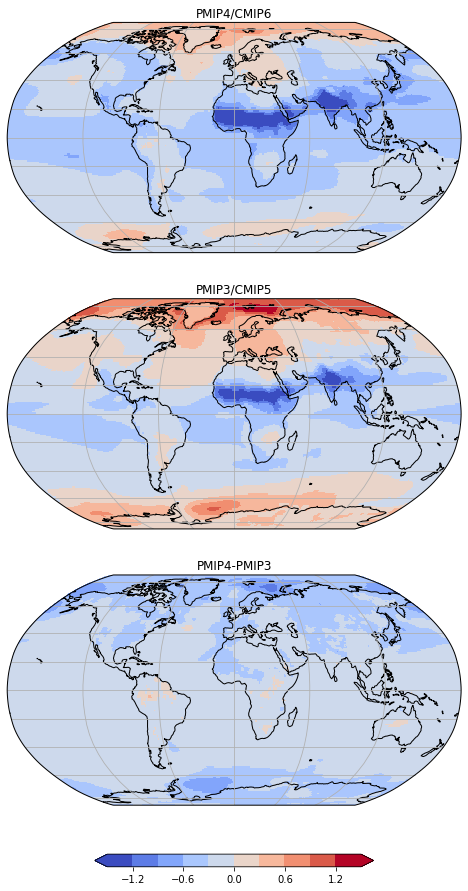

In [7]:
'''Annual mean temperature: ensemble average in deg_C, PMIP3 vs PMIP4.
Top two figures show the ensemble mean of changes (midHolocene minus piControl) in annual mean temperature in PMIP4 and PMIP3. 
The bottom one is the changes since PMIP3, it shows the difference between the top two figures.'''

tas_ave_plot(mat_ensemble_ave_v4,mat_ensemble_ave_v3,mat_ensemble_diff,experiment_name,variable_name)

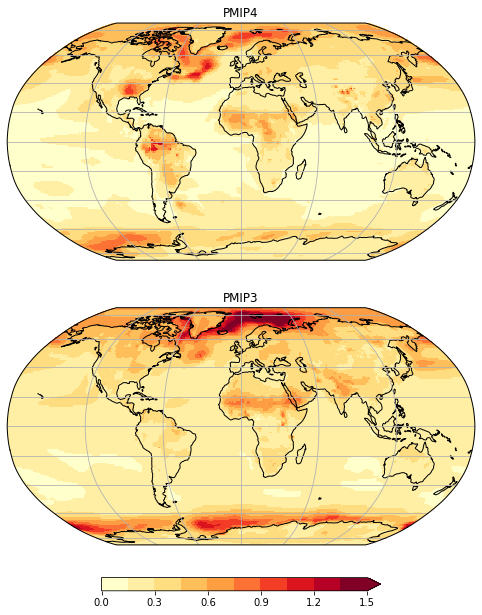

In [8]:
'''Annual mean temperature: ensemble uncertainty, PMIP3 vs PMIP4.
It shows the ensemble mean of standard deviation of changes (midHolocene minus piControl) in annual mean temperature in PMIP3. 
PMIP4 uncertainty is currently unavailable as we haven't got enough model data.'''

tas_std_plot(mat_ensemble_std_v4,mat_ensemble_std_v3,experiment_name,variable_name)

In [9]:
filename='plotting_data/PMIP4_MH_Ensembles_tas_ann.nc'
d=Dataset(filename,'a')
d.variables['tas_ann_ave_v3'][:]=mat_ensemble_ave_v3
d.variables['tas_ann_std_v3'][:]=mat_ensemble_std_v3
d.variables['tas_ann_ave_v4'][:]=mat_ensemble_ave_v4
d.variables['tas_ann_std_v4'][:]=mat_ensemble_std_v4
d.variables['tas_ann_ave_diff'][:]=mat_ensemble_diff

d.close()

# 3. Calculations -- seasonal cycle of surface temp

## DJF mean temperature

In [10]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_djf'


'''calculations'''
#PMIP3
djf_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
djf_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

djf_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
djf_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
djf_ensemble_diff=djf_ensemble_ave_v4-djf_ensemble_ave_v3





Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

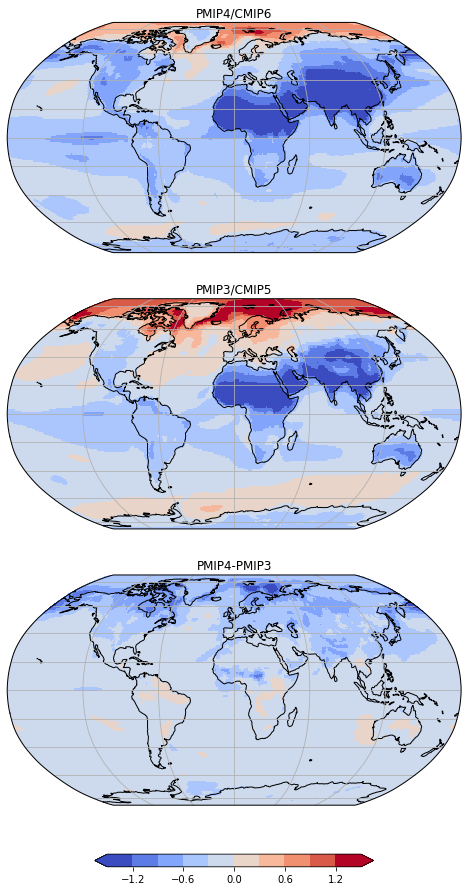

In [11]:
'''Changes in seasonal cycle of surface temp, DJF: ensemble average in◦C, PMIP3 vs PMIP4.
Top two figures show theensemble mean of changes (midHolocene-cal-adj minus piControl) in DJF mean temperature in PMIP4 and PMIP3. 
The bottom one is thechanges since PMIP3, it shows the difference between the top two figures.)'''

tas_ave_plot(djf_ensemble_ave_v4,djf_ensemble_ave_v3,djf_ensemble_diff,experiment_name,variable_name)

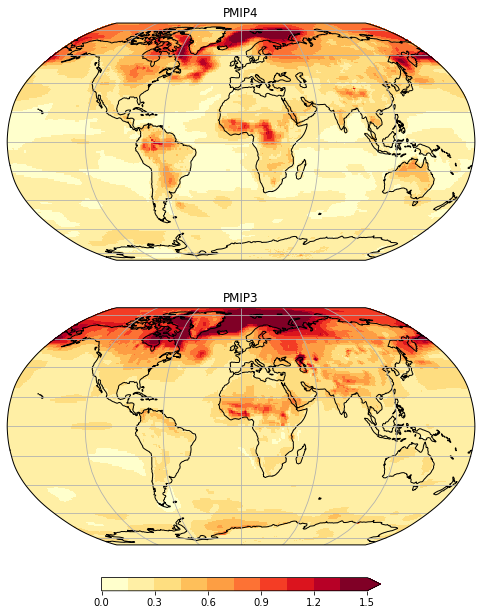

In [12]:
tas_std_plot(djf_ensemble_std_v4,djf_ensemble_std_v3,experiment_name,variable_name)

In [13]:
d=Dataset('plotting_data/PMIP4_MH_Ensembles_tas_djf.nc','a')

d.variables['tas_djf_ave_v4'][:]=djf_ensemble_ave_v4    
d.variables['tas_djf_std_v4'][:]=djf_ensemble_std_v4
d.variables['tas_djf_ave_v3'][:]=djf_ensemble_ave_v3    
d.variables['tas_djf_std_v3'][:]=djf_ensemble_std_v3
d.variables['tas_djf_ave_diff'][:]=djf_ensemble_diff  
d.close()

## JJA mean temperature

In [14]:
experiment_name='midHolocene-cal-adj'
variable_name='tas_spatialmean_jja'

jja_ensemble_ave_v3=ensemble_mean_diffence(pmip_v3,experiment_name,variable_name)
jja_ensemble_std_v3=ensemble_stddev(pmip_v3,experiment_name,variable_name)
#PMIP4

jja_ensemble_ave_v4=ensemble_mean_diffence(pmip_v4,experiment_name,variable_name)
jja_ensemble_std_v4=ensemble_stddev(pmip_v4,experiment_name,variable_name)
#diff
jja_ensemble_diff=jja_ensemble_ave_v4-jja_ensemble_ave_v3







Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_18

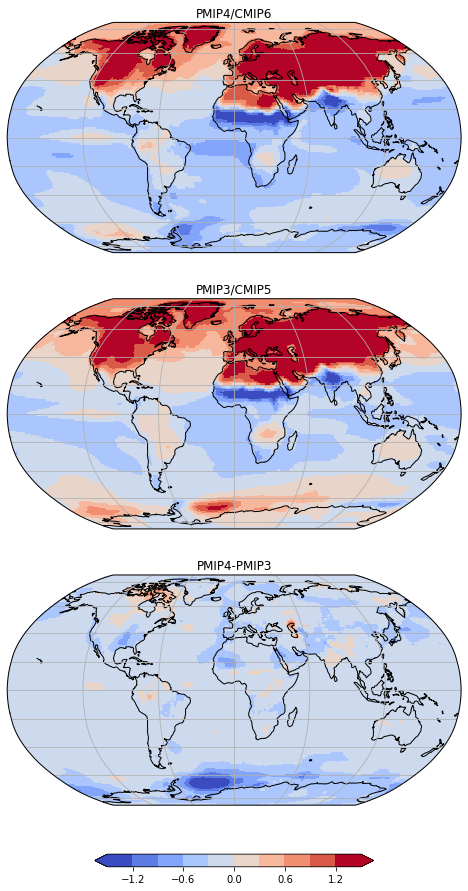

In [15]:
'''Same as DJF, but for JJA'''
tas_ave_plot(jja_ensemble_ave_v4,jja_ensemble_ave_v3,jja_ensemble_diff,experiment_name,variable_name)

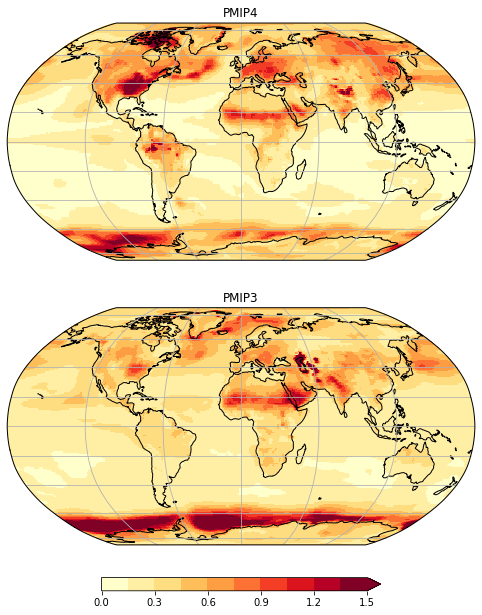

In [16]:
tas_std_plot(jja_ensemble_std_v4,jja_ensemble_std_v3,experiment_name,variable_name)

In [17]:
d=Dataset('plotting_data/PMIP4_MH_Ensembles_tas_jja.nc','a')

d.variables['tas_jja_ave_v4'][:]=jja_ensemble_ave_v4    
d.variables['tas_jja_std_v4'][:]=jja_ensemble_std_v4
d.variables['tas_jja_ave_v3'][:]=jja_ensemble_ave_v3    
d.variables['tas_jja_std_v3'][:]=jja_ensemble_std_v3
d.variables['tas_jja_ave_diff'][:]=jja_ensemble_diff  
d.close()

In [5]:
#No change needs here

'''Define plotting functions'''
#This fuction will plot Robinson projected Geo2D map for averaged temperature in deg_C
def tas_ave_plot1(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('coolwarm')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1.5,1.5]
    bounds = np.linspace(-1.5, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave1.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

#Same as above but for uncertainty, i.e. stddev
def tas_std_plot1(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlOrRd')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std1.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#This fuction will plot Robinson projected Geo2D map for averaged precipitation rate in mm/day
def pr_ave_plot1(data4,data3,data_diff,experiment_name,variable_name):
    cmap=plt.get_cmap('BrBG')
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    clim=[-1,1]
    bounds = np.linspace(-1, 1, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(10, 18), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]
    ax1.set_title('PMIP4/CMIP6 ')
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax2.set_title('PMIP3/CMIP5')
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=transform,cmap=cmap,clim=clim,norm=norm)
    ax3.set_title('PMIP4-PMIP3')
    ax3.coastlines()
    ax3.gridlines()
    fig3=ax3.imshow(data_diff, transform=transform,cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig3, cax=cax, **kw,extend='both')
    figname='figs/%s_%s_ave1.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    
#Same as above but for uncertainty, i.e. stddev
def pr_std_plot1(data4,data3,experiment_name,variable_name):
    cmap=plt.get_cmap('YlGn')
    clim=[0,1.5]
    bounds = np.linspace(0, 1.5, 11)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10, 12), subplot_kw={'projection': ccrs.Robinson()})
    ax1=axs[0]
    ax2=axs[1]
    title= 'PMIP4' 
    ax1.set_title(title)
    ax1.coastlines()
    ax1.gridlines()
    fig1=ax1.imshow(data4, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    title= 'PMIP3' 
    ax2.set_title(title)
    ax2.coastlines()
    ax2.gridlines()
    fig2=ax2.imshow(data3, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
    cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
    plt.colorbar(fig2, cax=cax, **kw,extend='max')
    figname='figs/%s_%s_std1.png' %(experiment_name,variable_name)
    plt.savefig(figname)
    

In [3]:
filename='plotting_data/PMIP4_MH_Ensembles_tas_ann.nc'

In [4]:
filename='plotting_data/PMIP4_MH_Ensembles_tas_ann.nc'
d=Dataset(filename)
ann3=d.variables['tas_ann_ave_v3'][:]
ann4=d.variables['tas_ann_ave_v4'][:]
anndiff=d.variables['tas_ann_ave_diff'][:]
d.close()

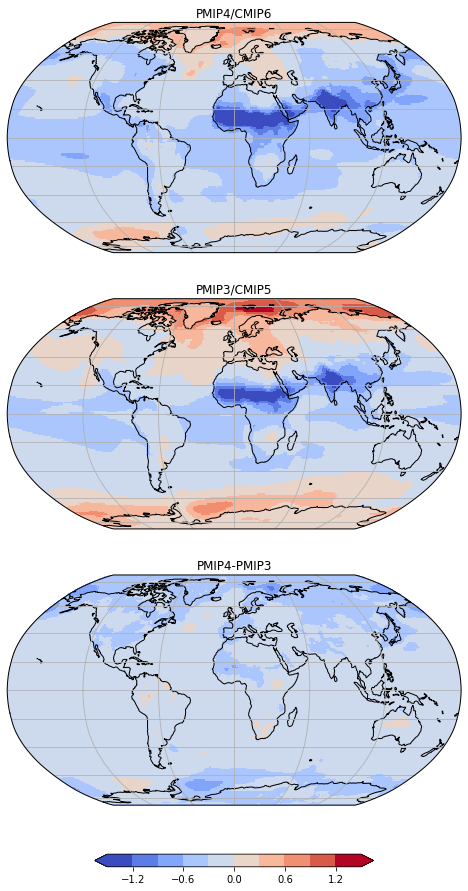

In [6]:
tas_ave_plot1(ann4,ann3,anndiff,'midHolocene','tas_spatialmean_ann')

In [7]:
filename='plotting_data/PMIP4_MH_Ensembles_tas_djf.nc'
d=Dataset(filename)
djf3=d.variables['tas_djf_ave_v3'][:]
djf4=d.variables['tas_djf_ave_v4'][:]
djfdiff=d.variables['tas_djf_ave_diff'][:]
d.close()
tas_ave_plot1(djf4,djf3,djfdiff,'midHolocene-cal-adj','tas_spatialmean_djf')

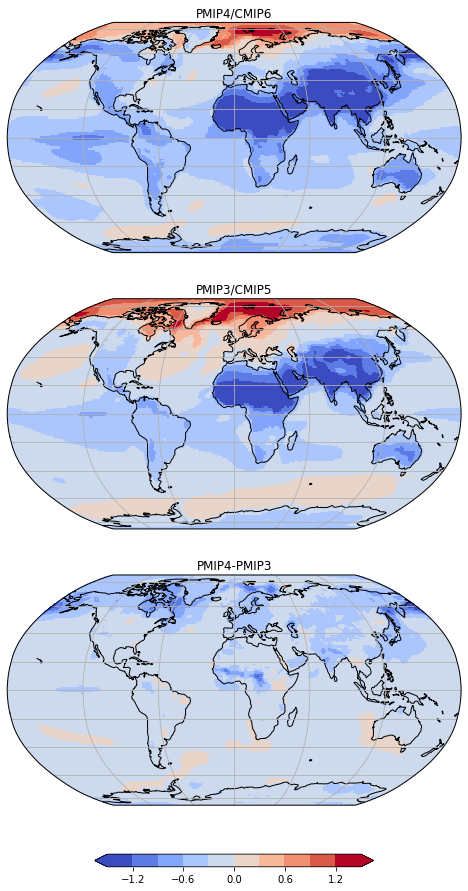

In [9]:
tas_ave_plot1(djf4,djf3,djfdiff,'midHolocene-cal-adj','tas_spatialmean_djf')

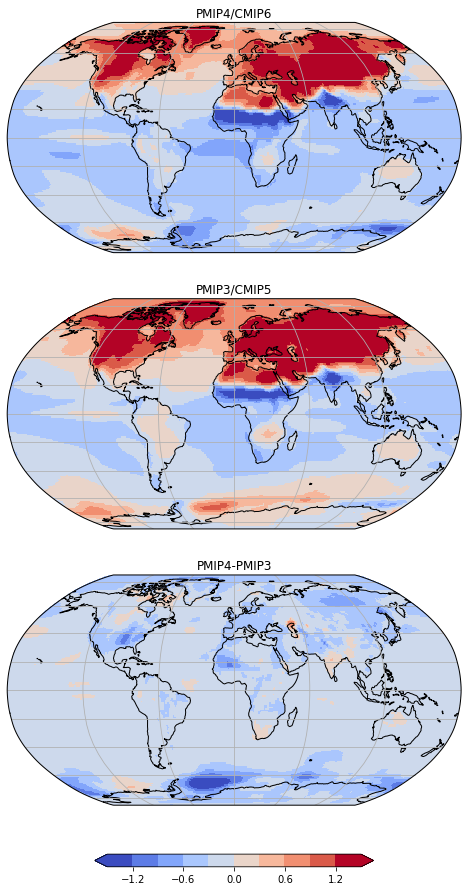

In [10]:
filename='plotting_data/PMIP4_MH_Ensembles_tas_jja.nc'
d=Dataset(filename)
jja3=d.variables['tas_jja_ave_v3'][:]
jja4=d.variables['tas_jja_ave_v4'][:]
jjadiff=d.variables['tas_jja_ave_diff'][:]
d.close()
tas_ave_plot1(jja4,jja3,jjadiff,'midHolocene-cal-adj','tas_spatialmean_jja')